In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

## VGG-16

#### Imports

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

import torchvision.models as models

#### Hyperparameters

In [3]:
batch_size = 128
num_epochs = 5
learning_rate = 0.05

transform = transforms.Compose(
  [transforms.Resize((224, 224)), # Resize images to 224x224 pixels
  transforms.ToTensor(), # Convert images to tensors
  transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))]) # Normalize images

#### Train-Validation-Test Sets

In [4]:
TRAIN_PATH = "/kaggle/input/intel-image-classification/seg_train/seg_train"
trainset = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform=transform)

validation_size = int(0.05 * len(trainset))
training_size = len(trainset) - validation_size

trainset , validationset = torch.utils.data.random_split(trainset, [training_size,validation_size]) 

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
print(f"Training Set Images : {len(trainset)}")

validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, shuffle=True)
print(f"Training Set Images : {len(validationset)}")

Training Set Images : 13333
Training Set Images : 701


In [5]:
TEST_PATH = "/kaggle/input/intel-image-classification/seg_test/seg_test"
testset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
print(f"Testing Set Images : {len(testset)}")

Testing Set Images : 3000


#### Activate GPU

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Fine-Tune

In [7]:
vgg16 = models.vgg16(pretrained=True)

# Setting up final layer (6 Classes)
num_classes = 6
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

# optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=learning_rate)

vgg16.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 261MB/s]  


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### Training

In [8]:
train_losses = []
train_accuracies = []

# Training Mode : On
vgg16.train()  
    
for epoch in range(num_epochs):
    
    print(f"\n\nProcessing Epoch : {epoch + 1}")
    
    running_loss = 0.0
    running_acc = 0.0
    
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = vgg16(inputs).to(device)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs, 1)
        acc = torch.sum(preds == labels).item() / batch_size
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_acc += acc
        
        if i % 50 == 49:
            print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss / 50, running_acc / 50))
            running_loss = 0.0
            running_acc = 0.0

    # Calculate training loss and accuracy for the epoch
    epoch_train_loss = running_loss / len(trainloader)
    epoch_train_acc = running_acc / len(trainloader)
    
    # Append training loss and accuracy to the lists
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)



Processing Epoch : 1
[1,    50] loss: 71243762936139849728.000 acc: 0.165
[1,   100] loss: 62.435 acc: 0.175


Processing Epoch : 2
[2,    50] loss: 1.834 acc: 0.157
[2,   100] loss: 1.802 acc: 0.172


Processing Epoch : 3
[3,    50] loss: 1.800 acc: 0.163
[3,   100] loss: 1.794 acc: 0.170


Processing Epoch : 4
[4,    50] loss: 1.793 acc: 0.175
[4,   100] loss: 1.792 acc: 0.177


Processing Epoch : 5
[5,    50] loss: 1.792 acc: 0.168
[5,   100] loss: 1.792 acc: 0.176


#### Validating

In [10]:
val_losses = []
val_accuracies = []

# Evaluation Mode : On
vgg16.eval()  

with torch.no_grad():
    for data in validationloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs, 1)
        acc = torch.sum(preds == labels).item() / batch_size

        # Append validation loss and accuracy to the lists
        val_losses.append(loss.item())
        val_accuracies.append(acc)

print('Validation Loss: %.3f Validation Accuracy: %.3f' % (np.mean(val_losses), np.mean(val_accuracies)))

Validation Loss: 1.790 Validation Accuracy: 0.172


#### Testing

In [11]:
test_losses = []
test_accuracies = []

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs, 1)
        acc = torch.sum(preds == labels).item() / batch_size

        # Append test loss and accuracy to the lists
        test_losses.append(loss.item())
        test_accuracies.append(acc)

print('Test Loss: %.3f Test Accuracy: %.3f' % (np.mean(test_losses), np.mean(test_accuracies)))

Test Loss: 1.790 Test Accuracy: 0.171


#### Visualization

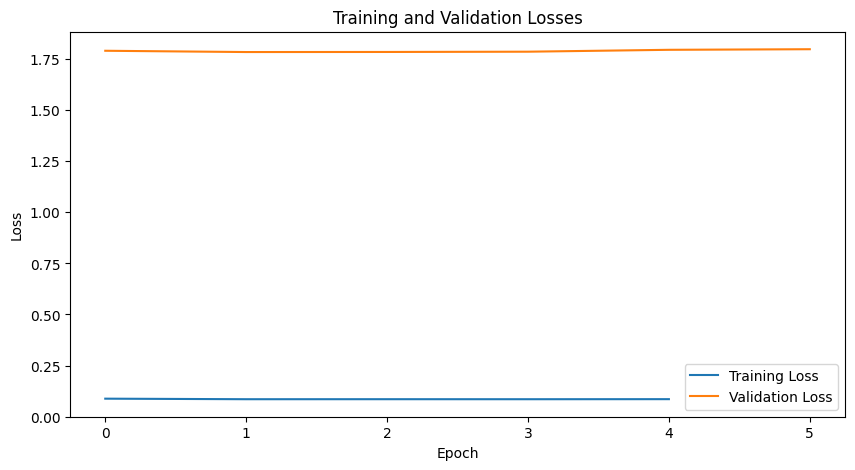

In [12]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Training and Validation Losses')
plt.legend()

plt.show()

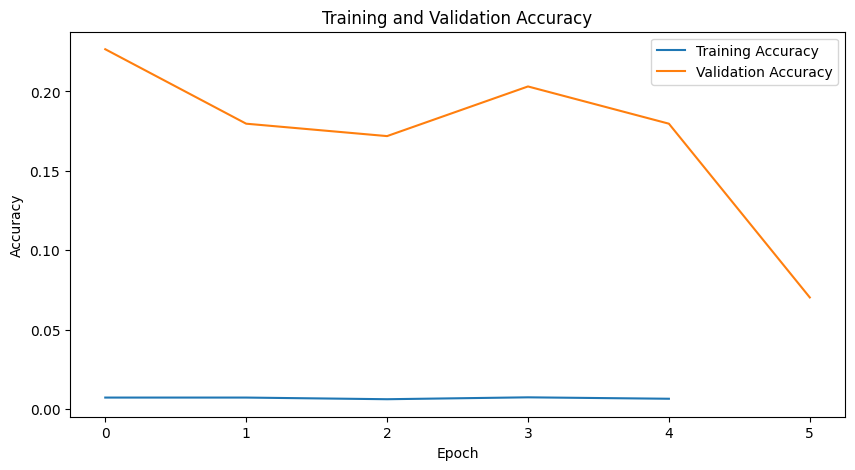

In [13]:
# Plot training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()